# Markowitz Model
## Efficient Frontier Portfolio Optimisation in Python

In [61]:
import numpy as np
import matplotlib.pyplot as plt
#Import Pandas web data access library
import pandas_datareader.data as web
import pandas as pd

#plt.style.use('fivethirtyeight')
plt.style.use('default')

In [ ]:
#Request quote information for Tesla's stock denoted by the symbol 'TSLA'
tslaQuote = web.DataReader('TSLA', data_source='yahoo', start='2016-01-01',
                           end='2017-12-31')
tslaQuote.head()

In [26]:
#Set the stock symbols, data source, and time range
stocks = ['AAPL','AMZN','GOOGL','FB']
numAssets = len(stocks)
source = 'yahoo'
start = '2016-01-01'
end = '2017-12-31'
data = {}

#Retrieve stock price data and save just the dividend adjusted closing prices
for symbol in stocks:
        data[symbol] = web.DataReader(symbol, data_source=source, start=start, end=end)['Adj Close']


In [32]:
data = pd.DataFrame.from_dict(data)
data.head()

,AAPL,AMZN,GOOGL,FB
Date,,,,
2016-01-04,24.286829,636.989990,759.440002,102.220001
2016-01-05,23.678219,633.789978,761.530029,102.730003
2016-01-06,23.214838,632.650024,759.330017,102.970001
2016-01-07,22.235067,607.940002,741.000000,97.919998
2016-01-08,22.352644,607.049988,730.909973,97.330002


Text(0.5, 0, 'Date')

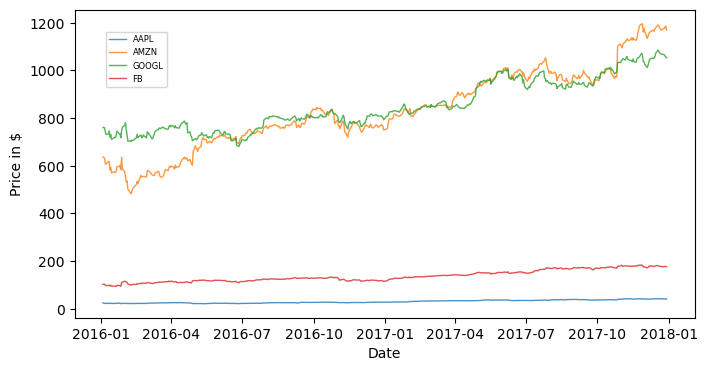

In [75]:
plt.figure(figsize=(8, 4))
for c in data.columns.values:
    plt.plot(data.index, data[c], lw=1, alpha=0.8,label=c)
plt.legend(loc=(.05,.75), fontsize=6)
plt.ylabel('Price in $')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

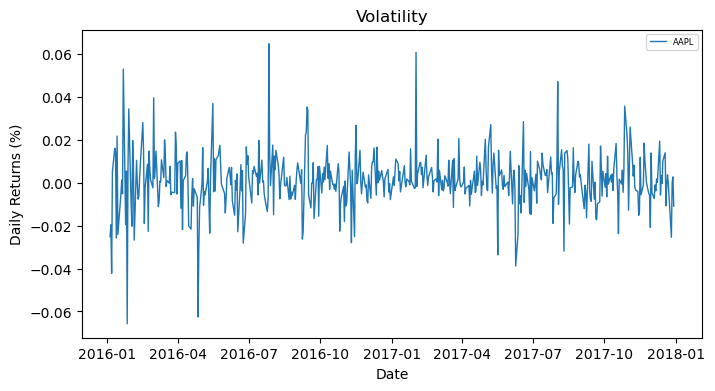

In [78]:
returns = data.pct_change()
plt.figure(figsize=(8, 4))
#for c in returns.columns.values:
    #plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.plot(returns.index, returns['AAPL'], label = 'AAPL', lw=1)
plt.legend(loc='upper right', fontsize=6)
plt.title('Volatility')
plt.ylabel('Daily Returns (%)')
plt.xlabel('Date')


In [82]:
# calculate daily and annual returns of the stocks
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

In [84]:
port_returns = []
port_volatility = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(stocks)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(stocks):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' weight' for stock in stocks]

# reorder dataframe columns
df = df[column_order]

df.head()

,Returns,Volatility,AAPL weight,AMZN weight,GOOGL weight,FB weight
0,0.282879,0.179691,0.259472,0.310771,0.175213,0.254544
1,0.251334,0.169146,0.303442,0.024617,0.344995,0.326946
2,0.261292,0.187543,0.079260,0.457226,0.432581,0.030933
3,0.256538,0.186751,0.020237,0.392071,0.463816,0.123877
4,0.260603,0.171854,0.261104,0.107935,0.300350,0.330612


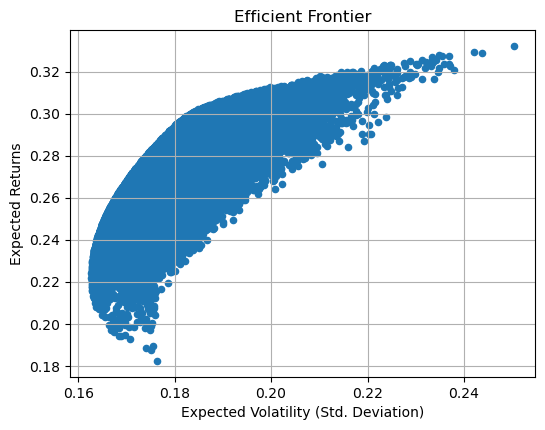

In [139]:
# plot the efficient frontier with a scatter plot
plt.style.use('default')
df.plot.scatter(x='Volatility', y='Returns', figsize=(6, 4.5), grid=True)
plt.xlabel('Expected Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [140]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns


def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record


returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178




def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)    
    
    
    plt.figure(figsize=(8, 5.6))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='x',color='b',s=400, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='x',color='r',s=400, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Returns')
    plt.legend(labelspacing=1)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN  GOOGL     FB
allocation  43.68  26.57   0.17  29.58
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.22
Annualised Volatility: 0.16


            AAPL  AMZN  GOOGL    FB
allocation  33.7  1.99  57.32  6.99


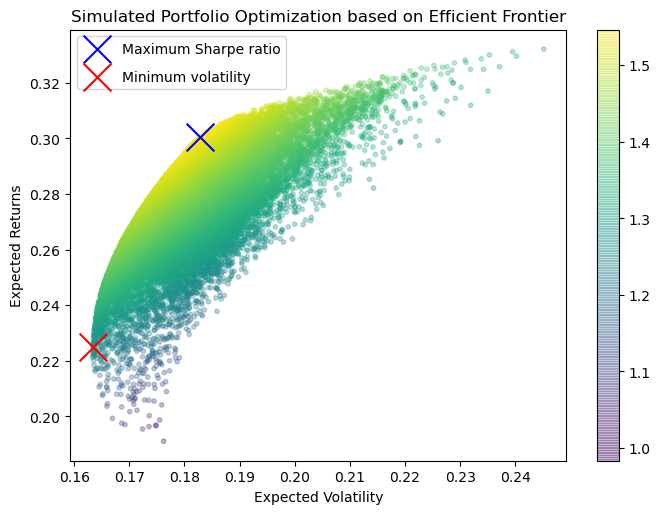

In [141]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Black-Scholes-Merton Model
## Options Pricing in Python

$\frac{\partial \mathrm C}{ \partial \mathrm t } + \frac{1}{2}\sigma^{2} \mathrm S^{2} \frac{\partial^{2} \mathrm C}{\partial \mathrm C^2}
	+ \mathrm r \mathrm S \frac{\partial \mathrm C}{\partial \mathrm S}\ =
	\mathrm r \mathrm C $
    
    
$\mathrm C(\mathrm S,\mathrm t)= \mathrm N(\mathrm d_1)\mathrm S_t - \mathrm N(\mathrm d_2) \mathrm K \mathrm e^{-rt}$

- C = Call option price 
- S$_t$ = Current stock price
- K = Strike price of the option
- r = Risk-free interest rate (a number between 0 and 1)
- $\sigma$ = Volatility of the stocks return (a number between 0 and 1)
- t = Time to option maturity (in years)
- N = normal cumulative distribution function

$\mathrm d_1= \frac{1}{\sigma \sqrt{\mathrm t}} \left[\ln{\left(\frac{S}{K}\right)} + t\left(r + \frac{\sigma^2}{2} \right) \right]$

$\mathrm d_2= \frac{1}{\sigma \sqrt{\mathrm t}} \left[\ln{\left(\frac{S}{K}\right)} + t\left(r - \frac{\sigma^2}{2} \right) \right]$

$N(x)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} \mathrm e^{-\frac{1}{2}z^2} dz$

In [150]:
from datetime import datetime, date
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

In [147]:
def d1(S,K,T,r,sigma):
    return(np.log(S/K)+(r+sigma**2/2.)*T)/(sigma*np.sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*np.sqrt(T)

In [148]:
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*np.exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))
  
def bs_put(S,K,T,r,sigma):
    return K*np.exp(-r*T)-S+bs_call(S,K,T,r,sigma)

In [151]:
stock = 'SPY'
expiry = '12-18-2022'
strike_price = 370

today = datetime.now()
one_year_ago = today.replace(year=today.year-1)

df = web.DataReader(stock, 'yahoo', one_year_ago, today)

df = df.sort_values(by="Date")
df = df.dropna()
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

sigma = np.sqrt(252) * df['returns'].std()
uty = (web.DataReader(
    "^TNX", 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1])/100
lcp = df['Close'].iloc[-1]
t = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365

print('The Option Price is: ', bs_call(lcp, strike_price, t, uty, sigma))

The Option Price is:  78.358218479676


In [154]:
def call_implied_volatility(Price, S, K, T, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = S * \
            norm.cdf(d1(S, K, T, r, sigma))-K*np.exp(-r*T) * \
            norm.cdf(d2(S, K, T, r, sigma))
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

def put_implied_volatility(Price, S, K, T, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = K*exp(-r*T)-S+bs_call(S, K, T, r, sigma)
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

print("Implied Volatility: " +
      str(100 * call_implied_volatility(bs_call(lcp, strike_price, t, uty, sigma,), lcp, strike_price, t, uty,)) + " %")


Implied Volatility: 13.600000000000009 %


In [186]:
options = {}
for symbol in stocks:
    df = web.DataReader(symbol, 'yahoo', one_year_ago, today)
    df = df.sort_values(by="Date")
    df = df.dropna()
    df = df.assign(close_day_before=df.Close.shift(1))
    df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)
    sigma = np.sqrt(252) * df['returns'].std()
    uty = (web.DataReader(
        "^TNX", 'yahoo', today.replace(day=today.day-1), today)['Close'].iloc[-1])/100
    lcp = df['Close'].iloc[-1]
    options[symbol] = bs_call(lcp, strike_price, t, uty, sigma)
    
options

{'AAPL': 0.019248659480856134,
 'AMZN': 2939.292947751972,
 'GOOGL': 2421.36301611135,
 'FB': 32.23937616390607}

Text(0.5, 0, 'Date')

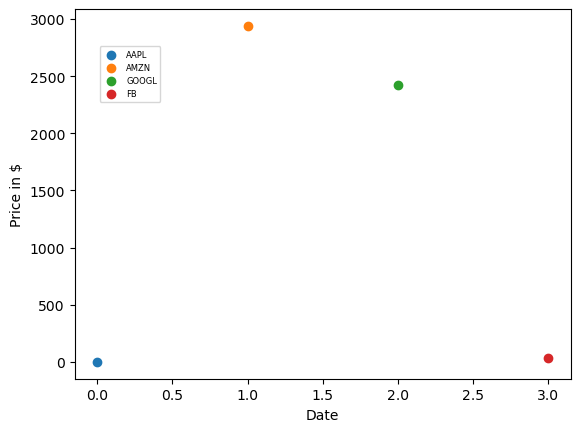

In [227]:
values = options.values()
keys = list(options.keys())
i = 0
for c in values:
    plt.scatter(i, c, label = keys[i])
    i = i+1
plt.legend(loc=(.05,.75), fontsize=6)
plt.ylabel('Price in $')
plt.xlabel('Date')